# High Dynamic Range (HDR) Imaging

## Import Libraries

In [1]:
import os
from urllib.request import urlretrieve
from zipfile import ZipFile

import cv2
import matplotlib.pyplot as plt
import numpy as np


## Download Assets

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting {url}")

    urlretrieve(url, save_path)

    try:
        with ZipFile(save_path) as z:
            z.extractall(os.path.split(save_path)[0])

        print("Done")
    except Exception as e:
        print("Invalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/qa1hsyxt66pvj02/opencv_bootcamp_assets_NB10.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB10.zip")

if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [4]:
def readImagesAndTime():
    filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]

    times = np.array([ 1/30.0, 0.25, 2.5, 15.0 ], dtype=np.float32)

    images = []
    for filename in filenames:
        im = cv2.imread(filename)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        images.append(im)

    return images, times



## Align Images

In [5]:
# read images and exposure times
images, times = readImagesAndTime()

# align images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

## Estimate Camera Response Function

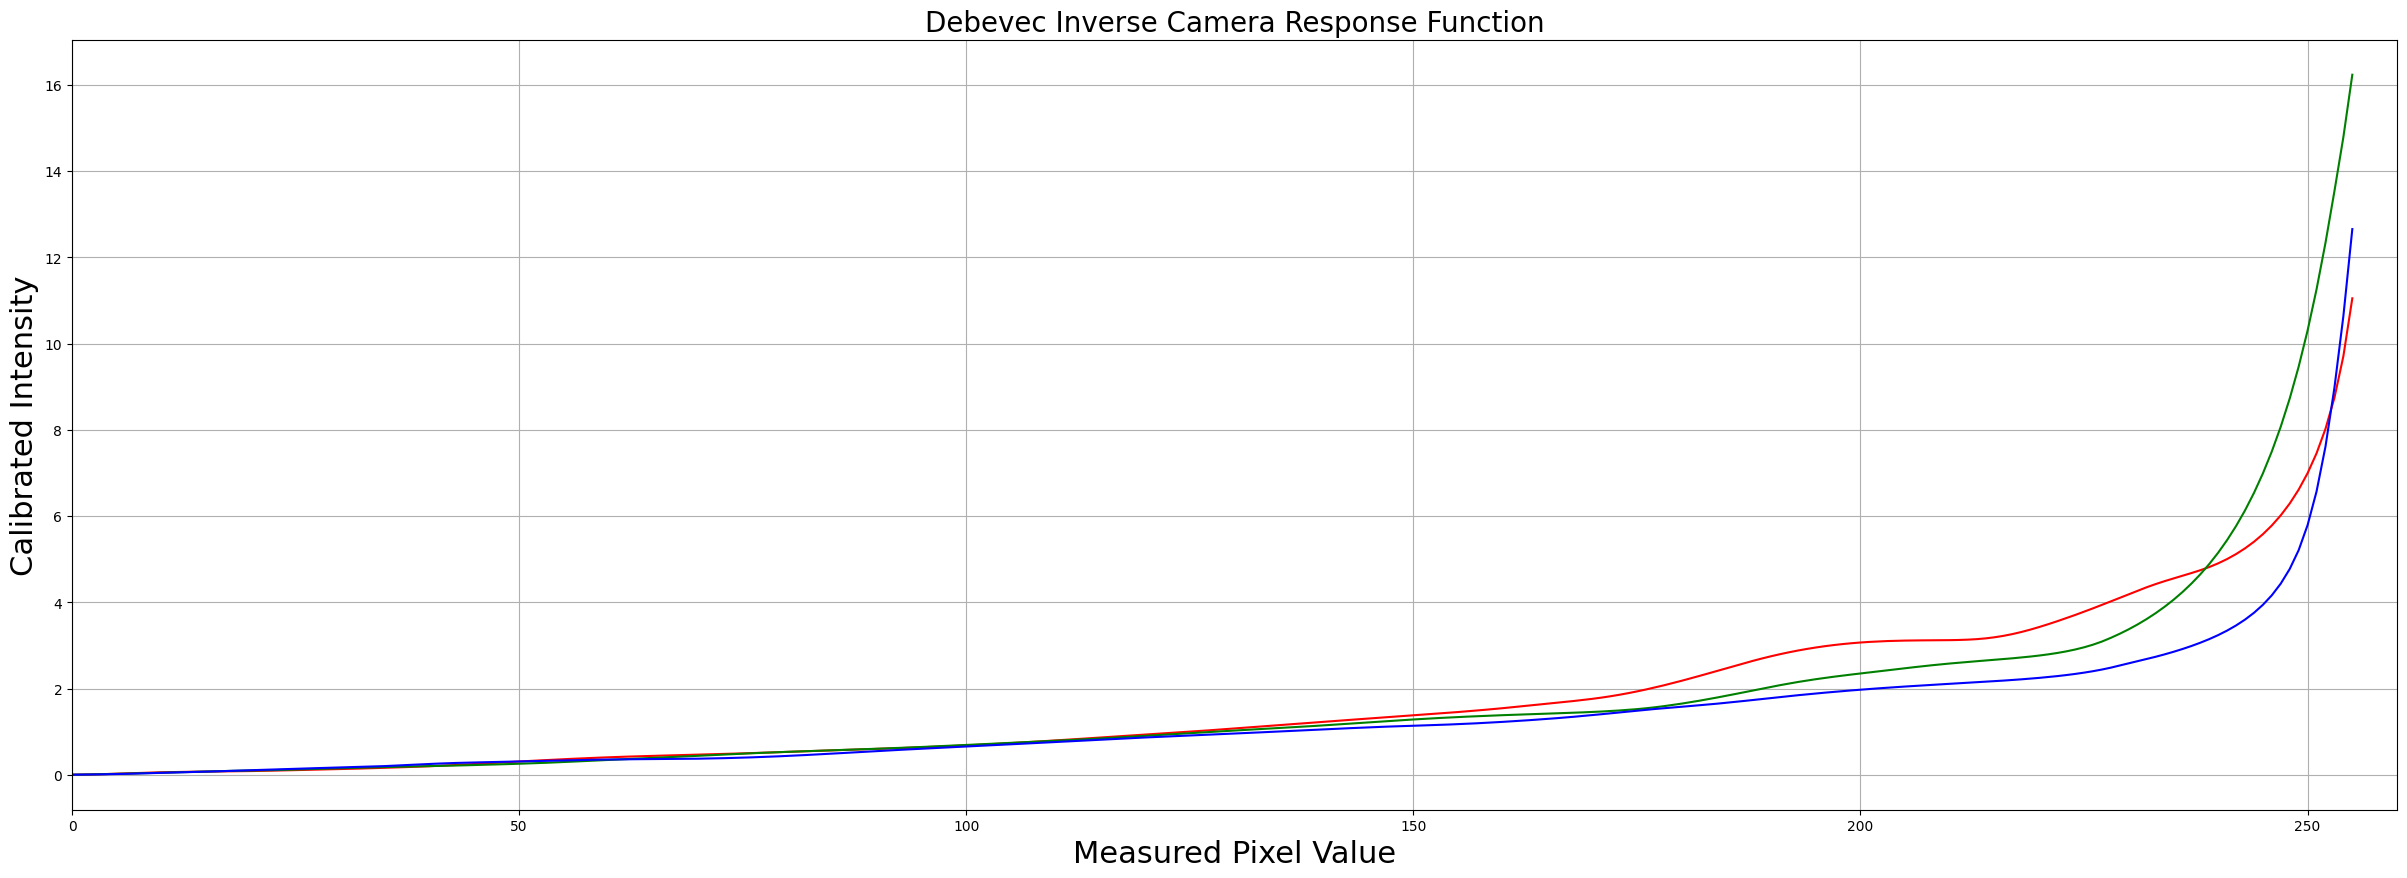

In [6]:
# camera response function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse Camera Response Function", fontsize=20)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:,0],'r', x, y[:,1],'g', x, y[:,2],'b')

## Merge Expose into an HDR Image

In [7]:
# merge image into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

## Tonemapping

[ WARN:0@1.599] global matrix_expressions.cpp:1334 assign OpenCV/MatExpr: processing of multi-channel arrays might be changed in the future: https://github.com/opencv/opencv/issues/16739
[ WARN:0@1.811] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


saved ldr-Drago.jpg


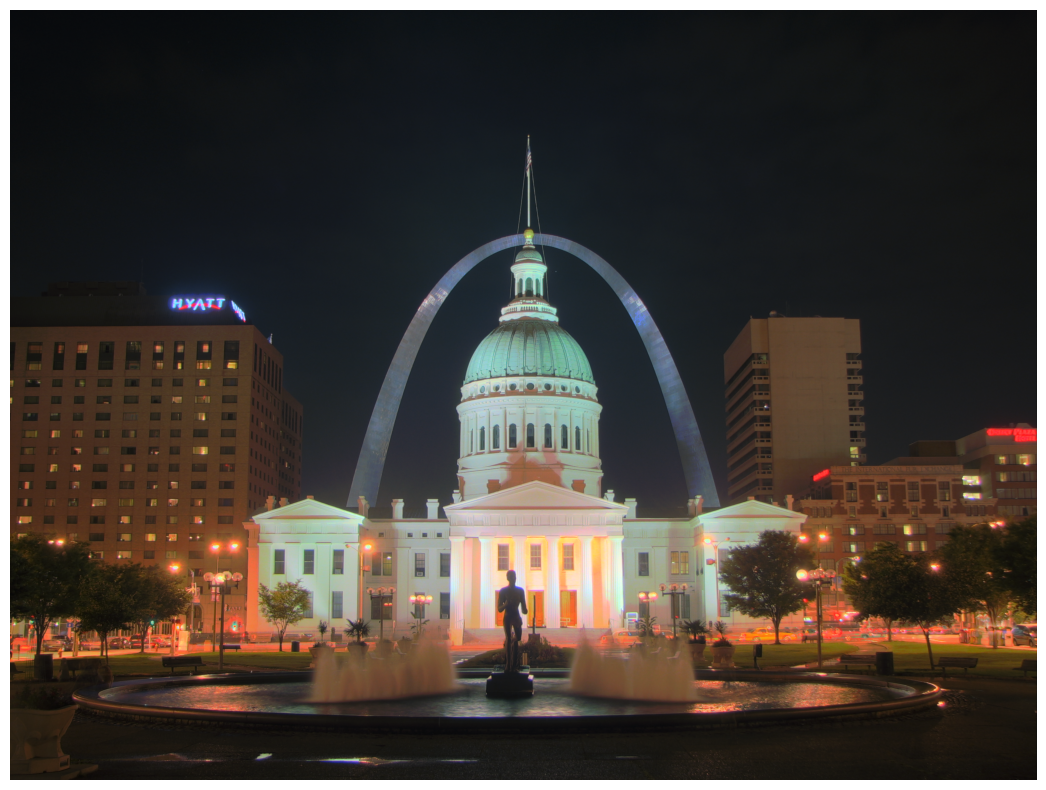

In [8]:
# Tonemap using Dragon's method
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago
plt.figure(figsize=(20, 10))
plt.imshow(np.clip(ldrDrago, 0, 1))
plt.axis("off")
cv2.imwrite("ldrDrago.png", ldrDrago * 255)
print("saved ldr-Drago.jpg")